# Back / Foreground separation
In this notebook we try to detect background pixels and remove them from image in order to keep only objets with different colour that, in our case, would be the panel we must operate on.\
We tested here the main idea, tuned the parameter for an optimal output, and then we will extend that to real scenario.\
This code is organized as follow:

**input:** single frame extracted from video stream

**output:** image of panel(ROI) with few other elements, polarized background
1. **decide when there is no panel in sight**: histogram distribution
2. **sample image to extract background color**: use mean/camshift to reach a particularly populated area wrt certaint distribution of pixels
3. **extract background pixel from the image**: backprojection
4. **result improvement**

((https://stackoverflow.com/questions/44825180/rectangle-document-detection-using-hough-transform-opencv-android))

https://docs.opencv.org/master/d7/d7b/classcv_1_1BackgroundSubtractorMOG2.html

https://docs.opencv.org/master/de/df4/tutorial_js_bg_subtraction.html

https://docs.opencv.org/master/d1/dc5/tutorial_background_subtraction.html

https://stackoverflow.com/questions/22133178/moving-background-subtraction-opencv

using background subtraction library, calculating background as the mean of various images (i.e. extracted frames from a video of the surraounding

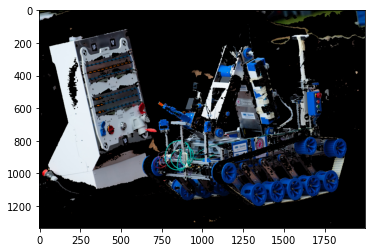

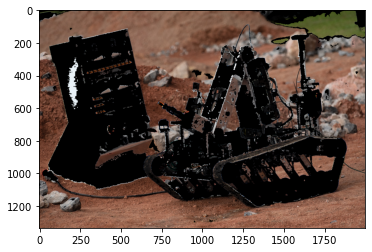

In [24]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob


####
# IMAGE STREAM ACQUISITION
#    video stream management?(elsewhere)
#.    first/usefull frames memorization
#    video stream (general) filtering
#
def bgVStream(srcBgVS):
    return cv.imread(srcBgVS)
img=bgVStream('../../images/marsyard/task-example.jpg')
foreGround=img.copy()

####
# IMAGE FILTERING/CONVERSION FOR COLOR ENHANCEMENT
#..    hsv space used (least inlfuence from environmental changes)
#    filtering for lowering noise/luminosity peaks
#    color clustering on histogram?
#    colored rocks recognition?
#
def bgPreFiltering(srcBgPF,paramBgPF=cv.COLOR_BGR2HSV):
    return cv.cvtColor(srcBgPF,paramBgPF)
imgh=bgPreFiltering(img)
####
# SOURCE HISTOGRAMS
####
# hist params
h_bins = 180
s_bins = 256
histSize = [h_bins, s_bins]
h_ranges = [0, 180]
s_ranges = [0, 256]
ranges = h_ranges + s_ranges
channels = [0, 1]
####
#..    computatation
#..    normalization
#

imghhist = cv.calcHist([imgh], channels, None, histSize, ranges, accumulate=False)
cv.normalize(imghhist, imghhist, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

####
# ROIs DEFINITION AND HISTOGRAMS
####
# CFD comparing methods and parameters
histCompLib = (
    ("Correlation", cv.HISTCMP_CORREL),
    ("Chi-Squared", cv.HISTCMP_CHISQR),
    ("Intersection", cv.HISTCMP_INTERSECT),
    ("Hellinger", cv.HISTCMP_BHATTACHARYYA),
    ("Kullback-Leibler",cv.HISTCMP_KL_DIV))
_,histCompMet=histCompLib[0]
roiMetLib=('library',
           'stream')
srcMetROi=roiMetLib[0]

compTresRoi=0
####
#    roi identification: 
#..       - samples library
#       - extraction from stream source:
#..           1) hardcoded dimension/ proportion of source's dimension
#.           2) rnd points/size
#           3) adaptive wrt source's features
#.           4) manual (human)
#
stackRoi=[]
if srcMetROi=='library':
    sampLibRoi='../../images/marsyard/samples/terrain/'
    # from samples directory
    # load all samples image in a vector
    for tempLibImg in glob.glob(sampLibRoi+"*.jpg"):#add a second for if many extensions
        stackRoi.append(cv.cvtColor(cv.imread(tempLibImg),cv.COLOR_BGR2HSV))
    sizeEl=7
    sizeEl2=sizeEl
    elemType=cv.MORPH_ELLIPSE
    threshval=50
                            
elif srcMetROi=='stream':
    # from splitting video source
    extrLibStream=('proportion',
                   'random',
                   'manual',
                   'adaptive')
    extrMetStream=extrLibStream[0]
    if extrMetStream=='proportion':
        dimRowRoi=img.shape[0]//5## add adaptivity wrt source features
        dimColRoi=img.shape[1]//5
        for jj in range(0,img.shape[0],dimRowRoi):
            for ii in range(0,img.shape[1],dimColRoi):
                stackRoi.append(cv.cvtColor(img[jj:jj+dimRowRoi,ii:ii+dimColRoi],cv.COLOR_BGR2HSV))
        sizeEl=2
    sizeEl2=sizeEl
    elemType=cv.MORPH_ELLIPSE
    threshval=30
#    elif extrMetStream=='random':
 #       roih=50
  #      roiw=50
   #     for (centerx,centery) in centers:
    #        #centerx,centery=func2extractcenter(image)
     #       roimg=image[centery-roih//2:centery+roih//2,centerx-roiw//2:centerx+roiw//2]
      #      roi.append(cv.cvtColor(roimg, cv.COLOR_BGR2HSV))
       #     interpolation=np.median
        #    roistack=np.stack(roi,axis=0)
         #   roimean=interpolation(roistack,axis=0)
    #elif extrMetStream=='manual':

####
# ADAPTIVE MASK
####
# parameters
## moved inside roi definition method because are dipending by that
## may be adaptable from roi dimension
#    roi hist filtering?
#.    roi histogram correllation testing:
#..        1) pass/non pass test to eliminate low correlated samples
#        2) mask weight proportional to correlation
#..    backprojection mask
#..    structuring element for planar filtering
#..    back/foreground separation
#
for roi2test in stackRoi:
    roihhist= cv.calcHist([roi2test], channels, None, histSize, ranges, accumulate=False)
    cv.normalize(roihhist, roihhist, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)
    if cv.compareHist(imghhist, roihhist, histCompMet)>compTresRoi:
        bpMask = cv.calcBackProject([imgh],channels,roihhist,ranges,1)
        disc = cv.getStructuringElement(elemType,(sizeEl2,sizeEl))
        
        cv.filter2D(bpMask,-1,disc,bpMask)
        _,thresh = cv.threshold(bpMask,threshval,255,0)
        thresh = cv.merge((thresh,thresh,thresh))
        foreGround = cv.bitwise_and(foreGround,cv.bitwise_not(thresh))

plt.imshow(cv.cvtColor(foreGround,cv.COLOR_BGR2RGB))
plt.show()
backGround=img-foreGround
plt.imshow(cv.cvtColor(backGround,cv.COLOR_BGR2RGB))
plt.show()
####
# MASK IMPROVEMENT
#    foreground filtering?
#    mini blobs remotion, especially in less/most transformed areas
#



####
# FOREGROUND TRACKING AND MASK ITERACTION
#    foreground histogram
#    foreground backprojection mask
#    foreground tracking with camshift
#    iterated foreground mask by tracking
#    total mask by summing back/foreground ones
#    new foreground identification and iteraction
#



In [4]:
def bgVStream(streamSource):#add source device ofsource of video stream
    return cv.imread(streamSource)

In [10]:
def bgpreFiltering(im2filter,bgFiltParam=cv.COLOR_BGR2HSV):
    return cv.cvtColor(im2filter,bgFiltParam)

In [ ]:
def bgForeDevide(image2mask,roiLibrary,maskParam):    
    h_bins = 180
    s_bins = 256
    histSize = [h_bins, s_bins]
    h_ranges = [0, 180]
    s_ranges = [0, 256]
    ranges = h_ranges + s_ranges
    channels = [0, 1]
    return roistack

    if srcMetROi=='library':
    sampLibRoi='../../images/marsyard/samples/terrain/'
    # from samples directory
    # load all samples image in a vector
    for tempLibImg in glob.glob(sampLibRoi+"*.jpg"):#add a second for if many extensions
        stackRoi.append(cv.cvtColor(cv.imread(tempLibImg),cv.COLOR_BGR2HSV))
    sizeEl=7
    sizeEl2=sizeEl
    elemType=cv.MORPH_ELLIPSE
    threshval=50
                            
elif srcMetROi=='stream':
    # from splitting video source
    extrLibStream=('proportion',
                   'random',
                   'manual',
                   'adaptive')
    extrMetStream=extrLibStream[0]
    if extrMetStream=='proportion':
        dimRowRoi=img.shape[0]//5## add adaptivity wrt source features
        dimColRoi=img.shape[1]//5
        for jj in range(0,img.shape[0],dimRowRoi):
            for ii in range(0,img.shape[1],dimColRoi):
                stackRoi.append(cv.cvtColor(img[jj:jj+dimRowRoi,ii:ii+dimColRoi],cv.COLOR_BGR2HSV))
        sizeEl=2
    sizeEl2=sizeEl
    elemType=cv.MORPH_ELLIPSE
    threshval=30
#    elif extrMetStream=='random':
 #       roih=50
  #      roiw=50
   #     for (centerx,centery) in centers:
    #        #centerx,centery=func2extractcenter(image)
     #       roimg=image[centery-roih//2:centery+roih//2,centerx-roiw//2:centerx+roiw//2]
      #      roi.append(cv.cvtColor(roimg, cv.COLOR_BGR2HSV))
       #     interpolation=np.median
        #    roistack=np.stack(roi,axis=0)
         #   roimean=interpolation(roistack,axis=0)
    #elif extrMetStream=='manual':

    for roi2test in stackRoi:
    roihhist= cv.calcHist([roi2test], channels, None, histSize, ranges, accumulate=False)
    cv.normalize(roihhist, roihhist, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)
    if cv.compareHist(imghhist, roihhist, histCompMet)>compTresRoi:
        bpMask = cv.calcBackProject([imgh],channels,roihhist,ranges,1)
        disc = cv.getStructuringElement(elemType,(sizeEl2,sizeEl))
        
        cv.filter2D(bpMask,-1,disc,bpMask)
        _,thresh = cv.threshold(bpMask,threshval,255,0)
        thresh = cv.merge((thresh,thresh,thresh))
        foreGround = cv.bitwise_and(foreGround,cv.bitwise_not(thresh))


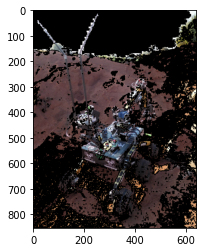

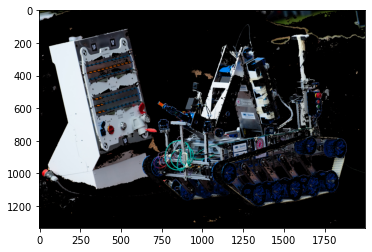

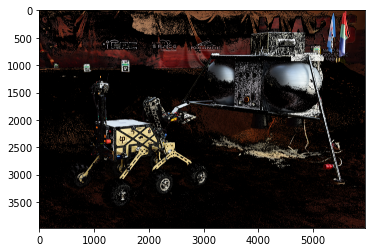

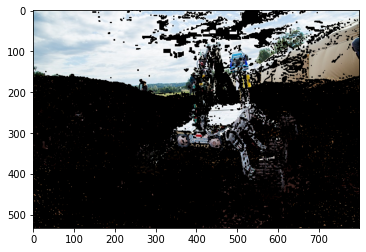

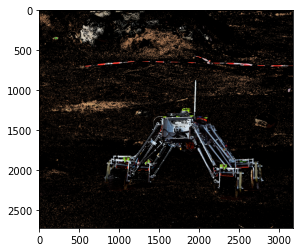

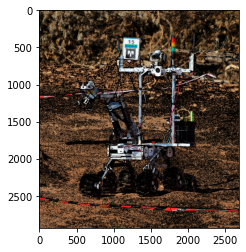

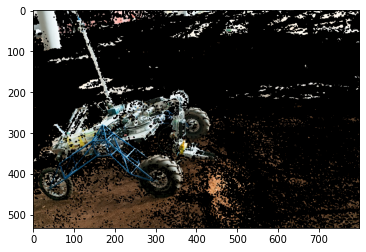

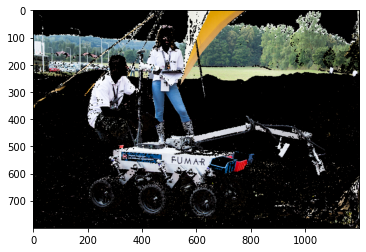

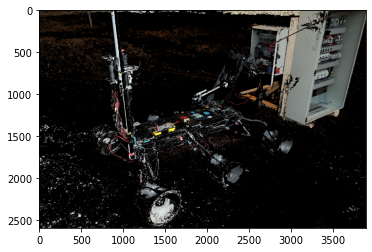

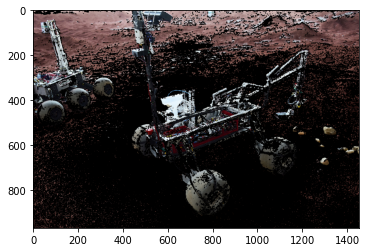

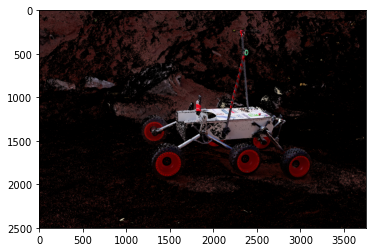

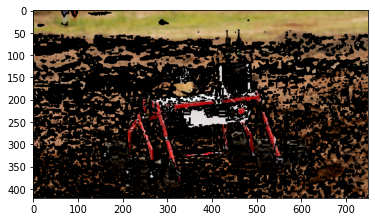

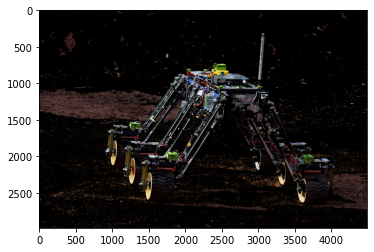

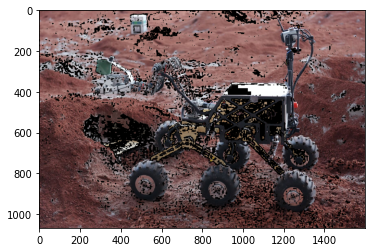

In [142]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

def bgVStream(srcBgVS):
    return cv.imread(srcBgVS)
def bgPreFiltering(srcBgPF,paramBgPF=cv.COLOR_BGR2HSV):
    return cv.cvtColor(srcBgPF,paramBgPF)

h_bins = 180
s_bins = 256
histSize = [h_bins, s_bins]
h_ranges = [0, 180]
s_ranges = [0, 256]
ranges = h_ranges + s_ranges
channels = [0, 1]

histCompLib = (
    ("Correlation", cv.HISTCMP_CORREL),
    ("Chi-Squared", cv.HISTCMP_CHISQR),
    ("Intersection", cv.HISTCMP_INTERSECT),
    ("Hellinger", cv.HISTCMP_BHATTACHARYYA),
    ("Kullback-Leibler",cv.HISTCMP_KL_DIV))

roiMetLib=('library',
           'stream')
srcImgLib='../../images/marsyard/'
for tempSrcImg in glob.glob(srcImgLib+"*.jpg"):
    img=bgVStream(tempSrcImg)#'../../images/marsyard/task1a.jpg')
    foreGround=img.copy()


    imgh=bgPreFiltering(img)



    imghhist = cv.calcHist([imgh], channels, None, histSize, ranges, accumulate=False)
    cv.normalize(imghhist, imghhist, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)


    _,histCompMet=histCompLib[1]
    srcMetROi=roiMetLib[0]
    stackRoi=[]
    compTresRoi=10000000#CORREL:0.4,CHISQR:10000000,INTERSECT:0.45,BHATTACHARYYA:?,KULLBACK:500
    stackRoi=[]
    if srcMetROi=='library':
        sampLibRoi='../../images/marsyard/samples/terrain/'
        for tempLibImg in glob.glob(sampLibRoi+"*.jpg"):#add a second for if many extensions
            stackRoi.append(cv.cvtColor(cv.imread(tempLibImg),cv.COLOR_BGR2HSV))
            sizeEl=3
            elemType=cv.MORPH_RECT
            threshval=10#CORREL:10, CHISQR:0-20,
            for roi2test in stackRoi:
                roihhist= cv.calcHist([roi2test], channels, None, histSize, ranges, accumulate=False)
                cv.normalize(roihhist, roihhist, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)
                if cv.compareHist(imghhist, roihhist, histCompMet)>compTresRoi:
                    bpMask = cv.calcBackProject([imgh],channels,roihhist,ranges,1)
                    cv.filter2D(bpMask,-1,cv.getStructuringElement(elemType,(sizeEl,sizeEl)),bpMask)
                    _,thresh = cv.threshold(bpMask,threshval,255,0)
                    thresh = cv.merge((thresh,thresh,thresh))
                    foreGround = cv.bitwise_and(foreGround,cv.bitwise_not(thresh))

    elif srcMetROi=='stream':
        elemNumber=4
        dimRowRoi=img.shape[0]//elemNumber
        dimColRoi=img.shape[1]//elemNumber
        for jj in range(0,img.shape[0],dimRowRoi):
            for ii in range(0,img.shape[1],dimColRoi):
                stackRoi.append(cv.cvtColor(img[jj:jj+dimRowRoi,ii:ii+dimColRoi],cv.COLOR_BGR2HSV))
                sizeEl=4
                elemType=cv.MORPH_RECT
                threshval=50
                for roi2test in stackRoi:
                    roihhist= cv.calcHist([roi2test], channels, None, histSize, ranges, accumulate=False)
                    cv.normalize(roihhist, roihhist, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)
                    if cv.compareHist(imghhist, roihhist, histCompMet)>compTresRoi:
                        bpMask = cv.calcBackProject([imgh],channels,roihhist,ranges,1)
                        cv.filter2D(bpMask,-1,cv.getStructuringElement(elemType,(sizeEl,sizeEl)),bpMask)
                        _,thresh = cv.threshold(bpMask,threshval,255,0)
                        thresh = cv.merge((thresh,thresh,thresh))
                        foreGround = cv.bitwise_and(foreGround,cv.bitwise_not(thresh))
    plt.imshow(cv.cvtColor(foreGround,cv.COLOR_BGR2RGB))
    plt.show()
#backGround=img-foreGround


hist comp met:  Correlation , source meth:  stream , size:  1 , compare tresh:  0.05 , element:  0 , size:  4 , filter thresh:  20 , 


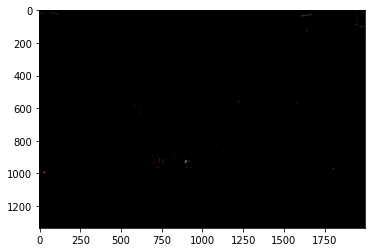

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

def bgVStream(srcBgVS):
    return cv.imread(srcBgVS)
img=bgVStream('../../images/marsyard/task-example.jpg')
foreGround=img.copy()

def bgPreFiltering(srcBgPF,paramBgPF=cv.COLOR_BGR2HSV):
    return cv.cvtColor(srcBgPF,paramBgPF)
imgh=bgPreFiltering(img)

h_bins = 180
s_bins = 256
histSize = [h_bins, s_bins]
h_ranges = [0, 180]
s_ranges = [0, 256]
ranges = h_ranges + s_ranges
channels = [0, 1]

imghhist = cv.calcHist([imgh], channels, None, histSize, ranges, accumulate=False)
cv.normalize(imghhist, imghhist, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

histCompLib = (
    ("Correlation", cv.HISTCMP_CORREL),
    ("Chi-Squared", cv.HISTCMP_CHISQR),
    ("Intersection", cv.HISTCMP_INTERSECT),
    ("Hellinger", cv.HISTCMP_BHATTACHARYYA),
    ("Kullback-Leibler",cv.HISTCMP_KL_DIV))
roiMetLib=('library',
           'stream')
#_,histCompMet=histCompLib[0]
#srcMetROi=roiMetLib[0]
for histCompMetstr,histCompMet in histCompLib:
    stackRoi=[]
    for srcMetROi in roiMetLib:

    #compTresRoi=0
        for compTresRoi in np.linspace(0.05,0.6,12):
            stackRoi=[]
            if srcMetROi=='library':
                sampLibRoi='../../images/marsyard/samples/terrain/'
                for tempLibImg in glob.glob(sampLibRoi+"*.jpg"):#add a second for if many extensions
                    stackRoi.append(cv.cvtColor(cv.imread(tempLibImg),cv.COLOR_BGR2HSV))
                #sizeEl=7
                for sizeEl in range(4,12):
                    #elemType=cv.MORPH_ELLIPSE
                    for elemType in(cv.MORPH_ELLIPSE,cv.MORPH_RECT):
                        #threshval=50
                        for threshval in range(5,60,5):
                            for roi2test in stackRoi:
                                roihhist= cv.calcHist([roi2test], channels, None, histSize, ranges, accumulate=False)
                                cv.normalize(roihhist, roihhist, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)
                                if cv.compareHist(imghhist, roihhist, histCompMet)>compTresRoi:
                                    bpMask = cv.calcBackProject([imgh],channels,roihhist,ranges,1)
                                    disc = cv.getStructuringElement(elemType,(sizeEl,sizeEl))

                                    cv.filter2D(bpMask,-1,disc,bpMask)
                                    _,thresh = cv.threshold(bpMask,threshval,255,0)
                                    thresh = cv.merge((thresh,thresh,thresh))
                                    foreGround = cv.bitwise_and(foreGround,cv.bitwise_not(thresh))
                            print('hist comp met: ',histCompMetstr,', source meth: ',srcMetROi,', size: ',1,', compare tresh: ',\
                      compTresRoi,', element: ',elemType,', size: ',sizeEl,', filter thresh: ',threshval,', ')
                            plt.imshow(cv.cvtColor(foreGround,cv.COLOR_BGR2RGB))
                            plt.show()
            
            elif srcMetROi=='stream':
                #elemNumber=5
                for elemNumber in range(1,10):
                    dimRowRoi=img.shape[0]//elemNumber
                    dimColRoi=img.shape[1]//elemNumber
                    for jj in range(0,img.shape[0],dimRowRoi):
                        for ii in range(0,img.shape[1],dimColRoi):
                            stackRoi.append(cv.cvtColor(img[jj:jj+dimRowRoi,ii:ii+dimColRoi],cv.COLOR_BGR2HSV))
                    #sizeEl=2
                    for sizeEl in range(2,6):
                        #elemType=cv.MORPH_ELLIPSE
                        for elemType in(cv.MORPH_ELLIPSE,cv.MORPH_RECT):
                            #threshval=30
                            for threshval in range(5,60,5):
                                for roi2test in stackRoi:
                                    roihhist= cv.calcHist([roi2test], channels, None, histSize, ranges, accumulate=False)
                                    cv.normalize(roihhist, roihhist, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)
                                    if cv.compareHist(imghhist, roihhist, histCompMet)>compTresRoi:
                                        bpMask = cv.calcBackProject([imgh],channels,roihhist,ranges,1)
                                        disc = cv.getStructuringElement(elemType,(sizeEl,sizeEl))

                                        cv.filter2D(bpMask,-1,disc,bpMask)
                                        _,thresh = cv.threshold(bpMask,threshval,255,0)
                                        thresh = cv.merge((thresh,thresh,thresh))
                                        foreGround = cv.bitwise_and(foreGround,cv.bitwise_not(thresh))
                                print('hist comp met: ',histCompMetstr,', source meth: ',srcMetROi,', size: ',1,', compare tresh: ',\
                          compTresRoi,', element: ',elemType,', size: ',sizeEl,', filter thresh: ',threshval,', ')
                                plt.imshow(cv.cvtColor(foreGround,cv.COLOR_BGR2RGB))
                                plt.show()
            #backGround=img-foreGround


## ADDENDUM

### on image prefiltering

### on roi acquisition

to reduce computation load, sample could be tested to avoid too much similarity with the previous one, harming the mean value (this part is deprecated since histogram stacking is no longer considered)

histogram stacking and averaging doesn't seem a good method, since more mask are simpler

### on histograms and correlation test

V channel excluded because it's heavily influenced by light/environment conditions

V channel ranges, bins, max value could be toggles

still H,S channel are device dependent, LAB space in indipendent

in opencv H €[0,179], while S,V €[0,255]

### on mask and parameters

